# Lab 5: Regression and Dimensionality Reduction
This exercise repeats the same scenario as Lab 4, but this time I train a regression model, i.e. a model for numeric prediction. I also add dimensionality reduction element to the training pipeline. Note that dimensionality reduction can be included in classification pipelines in the same way.

In this exercise, we aim at training a regression model for predicting the weight of a fish from its other characteristics. I will evaluate two regression algorithms, RandomForestRegressor and LinearRegression, to choose the better one for training the final model.

In [105]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## EDA
Checking my dataset for missing values and outliers.

In [106]:
df = pd.read_csv("./insurance.csv")
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [107]:
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


In [108]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [109]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [110]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


From the entries above, I can examine that 
- Min value of `age` is 18 and max in 64
- Theres no missing values in the dataset
- There are 4 values of `region` and southeast has 40 more enteries compared the the other, southwest, nothwest, notheast.
- Max value of `children` an individual has is 5 and min 0.

Zero children in the dataset could be an individual has no children or it could be a missing value, it's hard to tell.

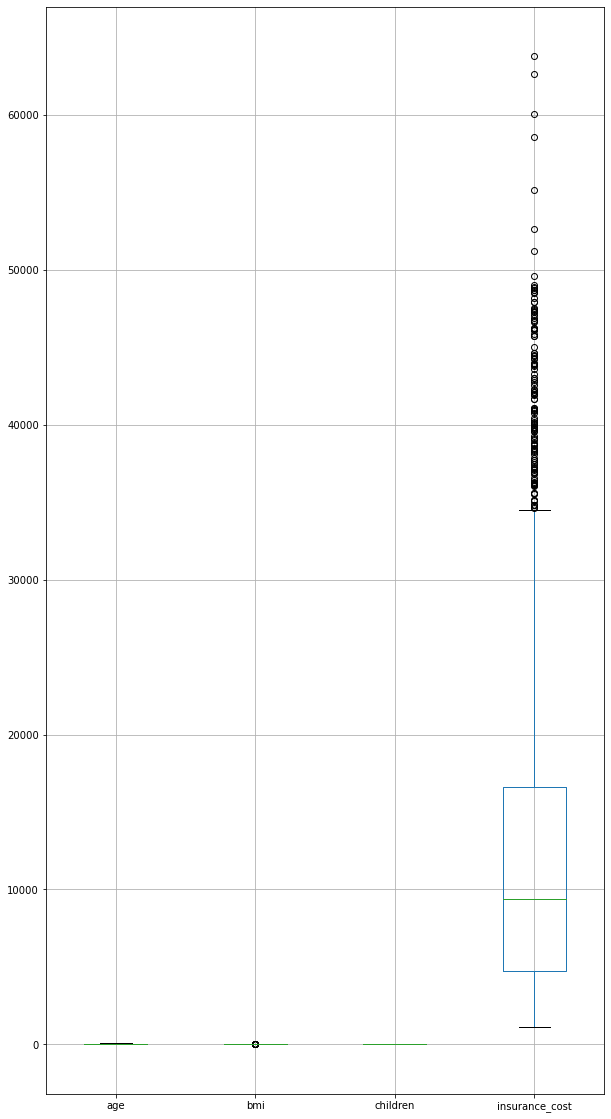

In [111]:
df.boxplot(figsize=(10,20))
plt.show()

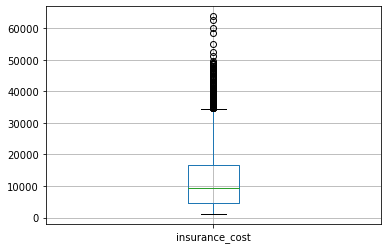

In [112]:
df.boxplot(column=['insurance_cost'])
plt.show()

We can see that `insurance_cost` has outliers but that's okay because some people have a really high insurance due to many factors.

## Data Preparation
Changing the values of `gender` , `smoker` and `region` so out ML algorithm can train on numerical values instead of categorical.

In [113]:
df = pd.get_dummies(df, columns=['gender','smoker','region'], 
                        #dummy_na=True, 
                        drop_first=True)

In [114]:
df.head()

,age,bmi,children,insurance_cost,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,18,33.770,1,1725.55230,1,0,0,1,0
1,18,34.100,0,1137.01100,1,0,0,1,0
2,18,26.315,0,2198.18985,0,0,0,0,0
3,18,38.665,2,3393.35635,0,0,0,0,0
4,18,35.625,0,2211.13075,0,0,0,0,0


In [115]:
df.tail()

,age,bmi,children,insurance_cost,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest
1333,64,31.825,2,16069.08475,0,0,0,0,0
1334,64,26.885,0,29330.98315,0,1,1,0,0
1335,64,26.410,0,14394.55790,1,0,0,0,0
1336,64,36.960,2,49577.66240,1,1,0,1,0
1337,64,23.760,0,26926.51440,1,1,0,1,0


I will apply __StandardScaler__ to all predictor columns with a very simple  pre-processing pipeline

In [116]:
preprocess_pipeline = make_pipeline(StandardScaler())

Now I can separate the columns into *target* and *predictors* and split the dataset into a training and test sets.

In [117]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Grid Search for Best Parameters and Best Dimensionality Reduction Method

Next, I train `RandomForestRegressor` on the training set with a range of possible parameters in order to find the best parameters by cross-validation. To do this I will build another [main] pipeline which includes the `preprocessing pipeline` and `RandomForestRegressor`. I also add an element for dimensionality reduction after the preprocessing pipeline.

Here I will attempt three different dimensionality reduction methods and I will let the grid search pick the best one. These are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator svm.SVR
- Recursive Feature Elimination (RFE) with estimator LinearRegression

Note that RFE is using regression algorithms for selecting the best features. These regression algorithms can be different from the regression algorithm at the end of the main pipeline.

The main pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation. It also applies the dimensionality reduction method separately to the two sets.

###  Random Forest Pipeline
The pipeline contains a placeholder for the dimensionality reduction method. I will treat the method as a parameter and let the grid search pick the best of the three methods.

In [118]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

I limit the parameter grid to a few options for the `max_depth` parameter of `RandomForestRegressor` and to three alternative values for the number of selected features by the dimensionality reduction method. More parameters and values can be explored. Here I limit the options to make sure the grid search does not take too long to execute.

In [119]:
N_FEATURES_OPTIONS = [2, 6, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.857:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__max_depth': 4}


The parameter `refit=True` makes the `GridSearchCV` train a `RandomForestRegressor` model on the whole training set with the best parameters and the best dimensionality reduction method found. This best model can then be accessed via the `.best_estimator_` attribute of the `GridSearchCV`.

Let's repeat the same experiment but with __LinearRegression__ for training a regression model.

## Linear Regression Pipeline

In [120]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [121]:
N_FEATURES_OPTIONS = [2, 6, 8]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.751:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': False}


The results suggest that Random Forest performs better. The cross-validation score is `1 - relative squared error`. The higher the score the more accurate the model. I can now further confirm this by comparing the best models on the test set.

In [122]:
from sklearn.svm import SVR
pipe = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

In [123]:
N_FEATURES_OPTIONS = [2, 6, 8]
NORMALIZE_OPTIONS = [False, True]

param_grid={
            'svr__C': [0.1, 1, 10, 100, 1000],
            'svr__epsilon': [0.0001, 0.0005,  0.001, 0.005,  0.01, 0.05, 1, 5, 10],
            'svr__gamma': [0.0001, 0.0005,  0.001, 0.005,  0.01, 0.05, 1, 5, 10]
        }

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVR_best_params = search.best_params_
SVR_best_model = search.best_estimator_

Best CV score = 0.665:
Best parameters:  {'svr__C': 1000, 'svr__epsilon': 10, 'svr__gamma': 0.05}


## Compare Regression Models on Test Set
Now I can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [124]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

I will use the function above to evaluate the best Random Forest and Linear Regression models found by the grid search.

In [125]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
SVR_mse, SVR_mae, SVR_r2 = evaluate_model(X_test, y_test, SVR_best_model)

In [126]:
SVR_mse

42102112.52043508

In [127]:
LR_mse

37300308.848984845

In [128]:
RF_mse

20175544.540426534

I will use a Pandas bar plots to compare the results.

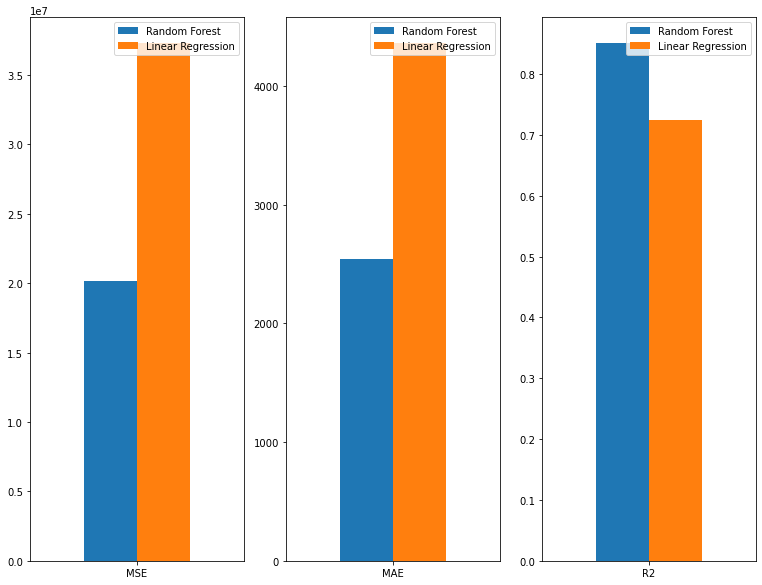

In [129]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 10))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

From the tests above i can visually see that the Random Forest alrigothm performs better than the Linear Reggression, with lower MSE and MAE and higher R2 

### Comparing results with my third Regression SVR

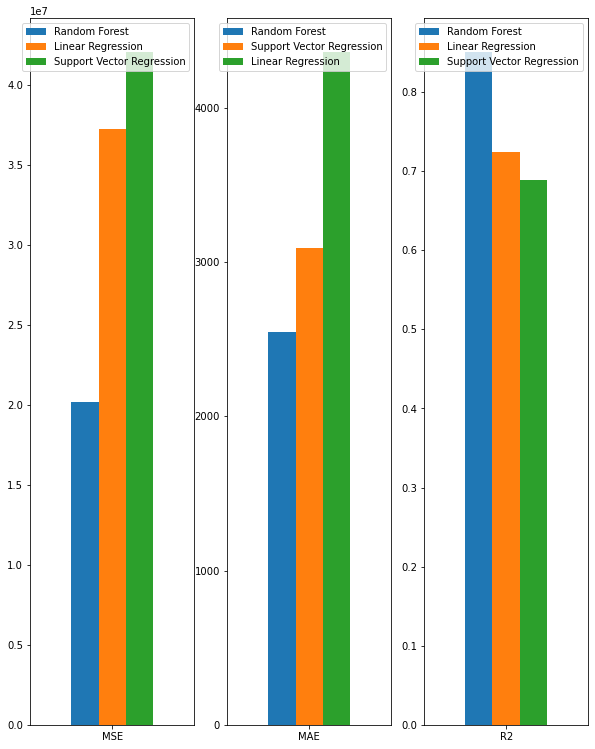

In [130]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'Support Vector Regression': SVR_mse },index=['MSE'])

df_mae = pd.DataFrame({'Random Forest': RF_mae,
                       'Support Vector Regression': SVR_mae,
                       'Linear Regression': LR_mae},
                      index=['MAE'])

df_r2 = pd.DataFrame({'Random Forest': RF_r2,
                      'Linear Regression': LR_r2,
                      'Support Vector Regression': SVR_r2},
                     index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 13))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

### COMPARING RESULTS

Comparing my results I can see that `Random Forest` is still the best regression model with lower MSE and MRE

`Support Vector Regression` is the worst out of all the regression algorithms.
with the highest MSE and MRE and lowest R2

This might be because I am yet to apply dimension reduction to the SVR.

## Train a Final Model
Finally, I can train a Random Forest regression model with all the data I have, assuming that the more data we have the better the model.

In [131]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

In [132]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))